In [1]:
import os
import json
import requests
from dotenv import load_dotenv
import plotly_express as px
load_dotenv()

True

In [2]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [3]:
api_key = os.getenv("API-KEY")
headers = {"Authorization":
           f"Bearer {api_key}"}

In [4]:
def get_quizzes(course_id, headers):
    """This function returns a list of JSONs
    that include all of the quizzes for a given course
    The main purpose for this function is to find the
    peer mentorship review quizzes we give the students
    but this would return useful data about any quizzes
    we were interested in.
    USAGE:
    This function requires that you have an API predefined.
    Most users won't notice this in the front end as we'll
    build the key into the program. If you're servicing in the
    future headers should look like:
    headers = {"Authorization":f"Bearer {api_key}"}
    jsons = get_quizes(400, headers)
    """
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes", headers=headers)
    raw = r.json()
    for i in raw:
        i["course_id"] = course_id
    return raw

In [5]:
def get_submissions(course_id, quiz_id, headers):
    """Creates a small list of jsons
    that can be made into a file very easily
    then converted to a dataframe for exploration
    This particular design is just for grabbing pagniated
    information from the api and returning it in a useful
    way.
    Usage:
    This function requires that you have an API predefined.
    Most users won't notice this in the front end as we'll
    build the key into the program. If you're servicing in the
    future headers should look like:
    headers = {"Authorization":f"Bearer {api_key}"}
    Example ids used, not real
    jsons = get_submissions(400, 1000)
    with open("some_json_title.json", "w") as outfile:
        json.dump(data_set, outfile)
    """
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions", headers=headers)
    data_set = []
    raw = r.json()

    for submission in raw["quiz_submissions"]:
        submission["course_id"] = course_id
        submission["quiz_id"] = quiz_id
        data_set.append(submission)

    if "next" in r.links.keys():
        while "next" in r.links.keys():
            r = requests.get(r.links["next"]["url"], headers=headers)
            raw = r.json()
            for submission in raw["quiz_submissions"]:
                submission["course_id"] = course_id
                submission["quiz_id"] = quiz_id
                data_set.append(submission)
        if "last" in r.links.keys() and r.links['current']['url'] == r.links['last']['url']:
            print('Done!')
    else:
        print("Just one page!")
    return data_set

In [6]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/accounts/1/courses?search_by=course&search_term=LLP&per_page=100", headers=headers)
r

<Response [200]>

In [7]:
raw = r.json()

with open("LLP-Courses.json", "w") as outfile:
    json.dump(raw, outfile)

In [9]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/accounts/1/users", headers=headers)
r

<Response [200]>

In [ ]:
llp_courses_df = pd.read_json("LLP-Courses.json")
llp_courses_df.head()

In [ ]:
llp_no_temp = llp_courses_df[llp_courses_df["course_code"].str.contains("Template")==False]
llp_no_temp.head()

In [ ]:
llp_2011_2010 = llp_no_temp[(llp_no_temp["course_code"].str.contains(pat = "201\d", regex = True))]
llp_2011_2010.head()

In [ ]:
quizzes_data = []
for i in llp_2011_2010["id"]:
    for t in get_quizzes(i, headers):
        quizzes_data.append(t)

In [ ]:
with open("quizzes_llp_201X.json", "w") as outfile:
    json.dump(quizzes_data, outfile)

In [ ]:
quizzes_df = pd.read_json("quizzes_llp_201X.json")
quizzes_df[["id","title", "course_id"]].head()

In [ ]:
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6780/submissions", headers=headers)
data_set = []
raw = r.json()

In [ ]:
for i in raw["quiz_submissions"]:
    i["course_id"] = 495 

In [ ]:
for i in quizzes_df[["id", "course_id"]].itertuples():
    submissions = get_submissions(i.course_id, i.id)
    with open(f"submissions_{i.id}.json", "w") as outfile:
        json.dump(submissions, outfile)

In [ ]:
subs_6585_df = pd.read_json("submissions_6585.json")
subs_6585_df.head()

In [ ]:
course_id = subs_6585_df["course_id"][1]
quiz_id = subs_6585_df["quiz_id"][1]
started_at = subs_6585_df["started_at"][0]
sub_id = subs_6585_df["id"][1]
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers) 

In [ ]:
raw2 = r.json()

for i in raw2["quiz_submission_events"]:
    if "event_data" in i.keys():
        if i["event_type"] == "question_answered":
            for t in i["event_data"]:
                if t["answer"] != None and 0 < t["answer"] < 4:
                    print(t["answer"]) 

In [8]:
import glob
subs_df = pd.DataFrame()
path_to_json = ""
json_pattern = os.path.join(path_to_json, "submissions_*.json")
files_list = glob.glob(json_pattern)

for f in files_list:
    data = pd.read_json(f)
    subs_df = subs_df.append(data)

In [9]:
subs_df

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url,course_id
0,57233,6585,103,633,309005,1.0,1.0,2020-10-26 22:47:46+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:50:48+00:00,1,complete,NaN,1,NaN,NaT,NaN,5e9f574072efc917ebfd543dadced88ad27cb1d1006bf73d8a1b26526534a1d3,NaN,0.0,86582.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57233,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57233&version=1,495
1,57294,6585,103,544,318896,1.0,1.0,2020-10-26 23:08:10+00:00,2020-11-21 07:59:59+00:00,2020-11-06 02:01:55+00:00,1,complete,NaN,1,NaN,NaT,NaN,4ea64d0996617807a3c655f8e95ae42a6319de0d8cb689915672fa930082ba58,NaN,0.0,874425.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57294,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57294&version=1,495
2,57299,6585,103,579,312007,1.0,1.0,2020-10-26 23:10:50+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,4f3a8e2ae3ffc807258bb85db4c2118255e51015d10a16734c5a3f7783c7d94c,NaN,NaN,2191748.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57299,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57299&version=1,495
3,57302,6585,103,1011,314947,1.0,1.0,2020-10-26 23:11:21+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:40:47+00:00,1,complete,NaN,1,NaN,NaT,NaN,48a83c07c6e2eeb9cbed95f48c820a5742591a781eb90c902c43b2346ec4739b,NaN,0.0,2064566.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57302,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57302&version=1,495
4,57366,6585,103,631,322392,1.0,1.0,2020-10-26 23:31:11+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:32:06+00:00,1,complete,NaN,1,NaN,NaT,NaN,17b98f2724d7708d8770f905b461972dd5675336ac89b578fa92240ebe22726f,NaN,0.0,82855.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57366,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57366&version=1,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,108106,8789,225,2813,551054,1.0,1.0,2020-12-10 00:07:18+00:00,2021-02-08 08:00:00+00:00,2020-12-10 00:07:28+00:00,1,complete,NaN,1,NaN,NaT,NaN,aeda659036adfc8804b1cde647e36ec093e8af37229d677f45ee90d62794f0b4,NaN,0.0,10.0,0,0.0,False,https://lambdaschool.instructure.com/courses/644/quizzes/8789/submissions/108106,https://lambdaschool.instructure.com/courses/644/quizzes/8789/history?quiz_submission_id=108106&version=1,644
10,108234,8789,226,2178,551046,1.0,1.0,2020-12-10 00:53:17+00:00,2021-02-08 08:00:00+00:00,2020-12-10 00:54:17+00:00,1,complete,NaN,1,NaN,NaT,NaN,0d6931b852c4183ba22ec836e538eafe74a9862dbf3854d6900a2fd6784e9aef,NaN,0.0,60.0,0,0.0,False,https://lambdaschool.instructure.com/courses/644/quizzes/8789/submissions/108234,https://lambdaschool.instructure.com/courses/644/quizzes/8789/history?quiz_submission_id=108234&version=1,644
11,108244,8789,226,2808,556003,1.0,1.0,2020-12-10 00:55:50+00:00,2021-02-08 08:00:00+00:00,2020-12-10 00:56:18+00:00,1,complete,NaN,1,NaN,NaT,NaN,e8a641b794f585881da2c728a3b541c5f59eba7dad9ec4c8b09d0ed77e183f7f,NaN,0.0,28.0,0,0.0,False,https://lambdaschool.instructure.com/courses/644/quizzes/8789/submissions/108244,https://lambdaschool.instructure.com/courses/644/quizzes/8789/history?quiz_submission_id=108244&version=1,644
12,109378,8789,248,1962,551043,1.0,1.0,2020-12-10 22:56:33+00:00,2021-02-08 08:00:00+00:00,2020-12-10 22:56:47+00:00,1,complete,NaN,1,

In [10]:
course_495 = subs_df[subs_df["course_id"]==495]
course_495

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url,course_id
0,57233,6585,103,633,309005,1.0,1.0,2020-10-26 22:47:46+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:50:48+00:00,1,complete,NaN,1,NaN,NaT,NaN,5e9f574072efc917ebfd543dadced88ad27cb1d1006bf73d8a1b26526534a1d3,NaN,0.0,86582.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57233,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57233&version=1,495
1,57294,6585,103,544,318896,1.0,1.0,2020-10-26 23:08:10+00:00,2020-11-21 07:59:59+00:00,2020-11-06 02:01:55+00:00,1,complete,NaN,1,NaN,NaT,NaN,4ea64d0996617807a3c655f8e95ae42a6319de0d8cb689915672fa930082ba58,NaN,0.0,874425.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57294,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57294&version=1,495
2,57299,6585,103,579,312007,1.0,1.0,2020-10-26 23:10:50+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,4f3a8e2ae3ffc807258bb85db4c2118255e51015d10a16734c5a3f7783c7d94c,NaN,NaN,2191748.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57299,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57299&version=1,495
3,57302,6585,103,1011,314947,1.0,1.0,2020-10-26 23:11:21+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:40:47+00:00,1,complete,NaN,1,NaN,NaT,NaN,48a83c07c6e2eeb9cbed95f48c820a5742591a781eb90c902c43b2346ec4739b,NaN,0.0,2064566.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57302,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57302&version=1,495
4,57366,6585,103,631,322392,1.0,1.0,2020-10-26 23:31:11+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:32:06+00:00,1,complete,NaN,1,NaN,NaT,NaN,17b98f2724d7708d8770f905b461972dd5675336ac89b578fa92240ebe22726f,NaN,0.0,82855.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57366,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57366&version=1,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,87979,6876,627,251,314716,1.0,1.0,2020-11-17 19:47:02+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,5a9f2364c356a540a9875f4df7f6025de4d56369d4676317296c460dbc52693b,NaN,NaN,303176.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6876/submissions/87979,https://lambdaschool.instructure.com/courses/495/quizzes/6876/history?quiz_submission_id=87979&version=1,495
175,90406,6876,671,577,323656,1.0,1.0,2020-11-19 16:25:54+00:00,2020-11-21 07:59:59+00:00,2020-11-19 16:27:49+00:00,1,complete,NaN,1,NaN,NaT,NaN,f8a8962046a56e269bf9dada9d02028ef0d4dc5224a9fc15c38ab8075a17beb0,NaN,0.0,116.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6876/submissions/90406,https://lambdaschool.instructure.com/courses/495/quizzes/6876/history?quiz_submission_id=90406&version=1,495
176,90487,6876,672,2468,307302,1.0,1.0,2020-11-19 16:51:53+00:00,2020-11-21 07:59:59+00:00,2020-11-19 16:52:20+00:00,1,complete,NaN,1,NaN,NaT,NaN,f34e930487b5c4636a6675fc1b1bf125da1bf6569dc265cc380b69823455898d,NaN,0.0,26.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6876/submissions/90487,https://lambdaschool.instructure.com/courses/495/quizzes/6876/history?quiz_submission_id=90487&version=1,495
177,90884,6876,675,1011,316164,1.0,1.0,2020-11-19 20:42:35+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:43:50+00:00,1,complete,NaN,1,Na

In [11]:

result_data = []
for row in subs_df[["id","user_id","quiz_id","started_at","course_id"]].iterrows():
    sub_id = row[1][0]
    user_id = row[1][1]
    quiz_id = row[1][2]
    started_at = row[1][3]
    course_id = row[1][4]
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers)
    raw = r.json()
    for i in raw["quiz_submission_events"]:
        if "event_data" in i.keys():
            if i["event_type"] == "question_answered":
                for t in i["event_data"]:
                    if t["answer"] != None and isinstance(t["answer"], float):
                        if t["answer"] != None and 0 < t["answer"] < 4:
                            result_data.append([user_id, t["answer"], started_at]) 

JSONDecodeError: Extra data: line 1 column 5 (char 4)

In [ ]:
result_data[0]

In [12]:
result_df = pd.DataFrame(result_data, columns=["user_id", "score", "started_at"])
result_df = result_df.sort_values("started_at")

In [23]:
fig = px.line(result_df,x="started_at", y="score", color="user_id")
fig.update_traces(mode="markers+lines")
fig.show()

In [ ]:
result_df["user_id"].unique()

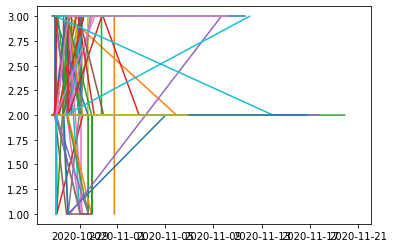

In [21]:
import matplotlib.pyplot as plt
for i in result_df["user_id"].unique():
    df = result_df[result_df["user_id"]==i]
    df = df.sort_values("started_at")
    plt.plot(df["started_at"], df["score"])
#plt.legend(result_df["user_id"].unique())
plt.show()

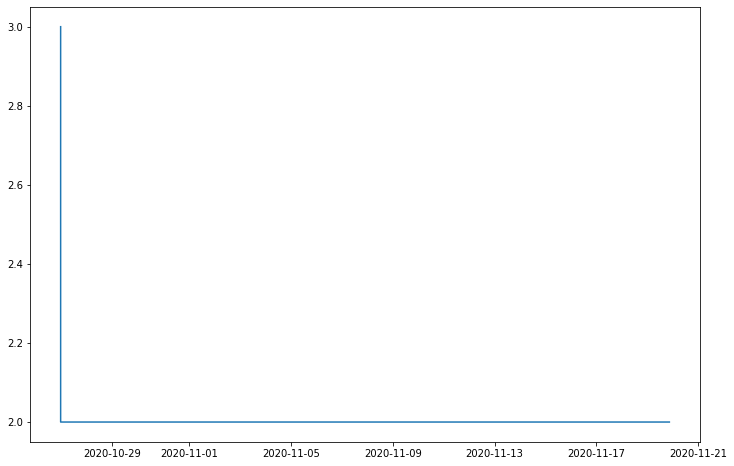

In [20]:
fig = plt.figure(figsize=(12,8))
df = result_df[result_df["user_id"]==1011]
df = df.sort_values("started_at")
plt.plot(df["started_at"], df["score"])
plt.show()

In [19]:
df.sort_values("started_at")

,user_id,score,started_at
516,1011,3.0,2020-10-26 23:10:51+00:00
2,1011,2.0,2020-10-26 23:11:21+00:00
457,1011,2.0,2020-11-19 20:38:41+00:00


In [ ]:
result_pivot = result_df.pivot(index="started_at", columns="user_id", values="score")
result_pivot.plot()

In [ ]:
st_544 = []
for i in result_data:
    if i[0] == 544:
        st_544.append(i)

In [ ]:
st_633 = []
for i in result_data:
    if i[0] == 633:
        st_633.append(i)

In [ ]:
st_544_633 = st_544+st_633
st_544_633

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i[2] for i in st_633], [i[1] for i in st_633])

In [ ]:
counts = {3:0,2:0,1:0}
for i in result_data:
    if i[1] == 1:
        counts[1]+=1
    if i[1] == 2:
        counts[2]+=1
    if i[1] == 3:
        counts[3]+=1
counts

In [ ]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(),counts.values(), color=["green", "grey", "red"])

In [ ]:
result_data
[i for i in result_data if i[0]==633]

In [ ]:
user_633 = course_495[course_495["user_id"]==633]
user_633

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions", headers=headers)
r

In [ ]:
raw = r.json()

with open("submissions-6617.json","w") as outfile:
    json.dump(raw["quiz_submissions"], outfile)

In [ ]:
sub_df_6617 = pd.read_json("submissions-6617.json")
sub_df_6617.head()

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions/57046/events", headers=headers)
r

In [ ]:
raw = r.json()["quiz_submission_events"]
for i in raw:
    i["user_id"] = 530

In [ ]:
with open("events-57046.json", "w") as outfile:
    json.dump(raw, outfile)

In [ ]:
events_df_57046 = pd.read_json("events-57046.json")
events_df_57046

In [ ]:

def get_answer(df):
    for i in df["event_data"]:
        if isinstance(i, list) and isinstance(i[0], str)==False:
            if "22635" in i[0].values():
                print(i[0]["answer"])
get_answer(events_df_56623)

In [ ]:
course_id = 495
quiz_id = 6780
submission_id = 56623
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{submission_id}/events", headers=headers)
r